In [94]:
from PIL import Image,ImageEnhance
from pathlib import Path
from skimage import measure
import numpy as np
import re
import ntpath
import random
from copy import deepcopy
import tqdm


In [95]:
class imclass:
    def __init__(self,id,im_list,mask_list,total_area):
        self.classid = id
        self.area = total_area
        self.im_list = im_list
        self.mask_list = mask_list

class im:
    def __init__(self,img,area,obj):
        self.img= img
        self.area = area
        self.obj =  obj



In [91]:
#todo:add class id and track area of each class
#add maximum overlapp\
import builtins
range = builtins.range

In [92]:
iter_order = [2,10,5,4,6,11,7,9,8,12,3,1]


DLinputsz = (1024,1024) #dimension of collage
background_ratio = 0.7
collage_area = DLinputsz[0]* DLinputsz[1] * background_ratio #this is a floa

#maximum overlapping between annotations, TODO
max_overlapping_area= 500




In [93]:
img_path = list(Path(r'\\fatherserverdw\kyuex\great\mask and crop').glob('*imcrop'))
mask_path  =  list(Path(r'\\fatherserverdw\kyuex\great\mask and crop').glob('*mskcrop'))


In [87]:
#randomly rescale (0.95 - 1.05)
# and randomly rotate (0,365)

In [120]:
#augment image color

import imgaug.augmenters as iaa
aug = iaa.WithHueAndSaturation(
    iaa.WithChannels(0, iaa.Add((-20, 20))),
    iaa.WithChannels(1, [
        iaa.Multiply((0.9, 1.1)),
        iaa.LinearContrast((0.9, 1.1))
    ])
)


temp = Image.open(r'\\fatherserverdw\kyuex\great\mask and crop\2022-06-07 13.18.40imcrop\class2_obj2.png').convert('RGB')
imarr = np.array(temp)
imarr.shape


(98, 99, 3)

In [170]:
im = aug.augment_image(np.array(temp))

In [ ]:
from matplotlib import pyplot as plt

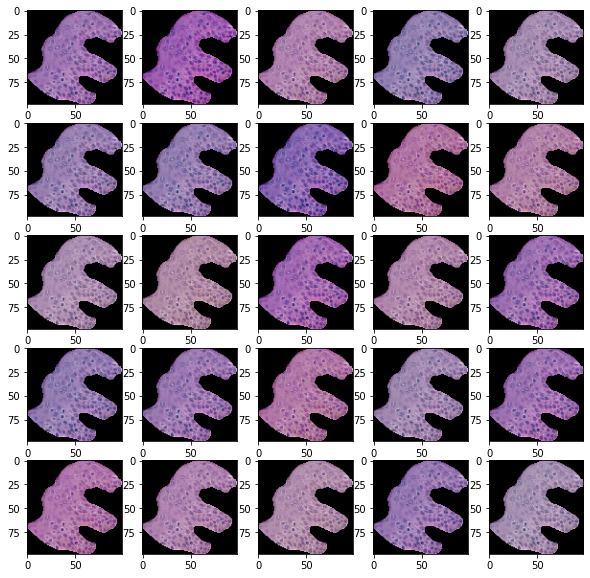

In [169]:
#optimize augmenter
aug = iaa.WithHueAndSaturation([
    iaa.WithChannels(0, iaa.Add((-20, 20))), #-30 30
    iaa.WithChannels(1, [
        iaa.Multiply((0.7, 1.3)), #0.5 1.5
        iaa.LinearContrast((0.7, 1.3))
    ])
])
rows = 5
fig,ax =plt.subplots(rows,rows,figsize=(10,10))
for i in range(rows):
    for j in range(rows):
        im = aug.augment_image(np.array(temp))
        ax[i][j].imshow(im)

In [100]:
for i in range(0,1):
    folder_dir = img_path[i]
    class_im_list=[[] for i in range(13)]

    for path in folder_dir.glob('*.png'):
        image = Image.open(path)
        objid= re.findall("obj(\d+).png", ntpath.basename(path))
        image_arr = np.array(image) #change image into a numpy array?
        area = np.sum(image_arr>0) #get the area of image minus black background\
        im_obj = im(image,area,objid) #create an image object

        classid = re.findall("class(\d+)_", ntpath.basename(path))[0]

        class_im_list[int(classid)].append(im_obj)




    folder_mask_dir = mask_path[i]
    class_mask_list=[[] for i in range(13)]

    for path in folder_mask_dir.glob('*.png'):
        image = Image.open(path)
        objid= re.findall("obj(\d+).png", ntpath.basename(path))
        image_arr = np.array(image) #change image into a numpy array?
        area = np.sum(image_arr>0) #get the area of image minus black background\
        im_obj = im(image,area,objid) #create an image object

        classid = re.findall("classnew(\d+)_", ntpath.basename(path))[0]

        class_mask_list[int(classid)].append(im_obj)


    classobj_list=[]
    num_class = 0
    for id in iter_order:
        classobj_list.append(imclass(id,class_im_list[id],class_mask_list[id],0))
        if(len(class_im_list[id]) != 0):
            num_class += 1



    filled_area = 0
     #there are 12 classes
    class_area = collage_area / num_class #float: the area each class should occupy
    class_threshold = 20; # you can exceed class area by 20

    imgblank= Image.new(mode="RGB",size=DLinputsz)
    maskblank = Image.new(mode="L",size=DLinputsz)
    classblank = Image.new(mode="L",size=DLinputsz)

    #create random generator
    random.seed()


    #generate tiles
    class_notfull = True
    filled_class = []

    while(filled_area < collage_area and class_notfull):
        for classobj in classobj_list:
            r = len(classobj.im_list)
            # this is looping through the classobj_list again and again,
            # if you change "if" to "while", then it's looping through one class at a time
            if(classobj.area < class_area and len(classobj.im_list) != 0):
                #pick random images from this class and paste
                if(len(classobj.im_list) == 0):
                    break
                elif(len(classobj.im_list) == 1):
                    image = classobj.im_list[0]
                    mask = classobj.mask_list[0]

                else:
                    idx = random.randint(0, r-1)
                    image = classobj.im_list[idx]
                    mask = classobj.mask_list[idx]

                #rotate and rescale
                scale =  random.uniform(0.95,1.05)
                rot = random.randint(0,365)
                new_width =  (image.img.size)[0] / scale
                new_height = (image.img.size)[1] / scale
                new_size = (np.round(new_width).astype(np.uint32),np.round(new_height).astype(np.uint32))
                new_img = image.img.rotate(rot)
                new_mask = mask.img.rotate(rot)

                new_img = new_img.resize(new_size)
                new_mask = new_mask.resize(new_size)


                binary_mask = np.array(new_mask)
                binary_mask[binary_mask > 0] = 1
                old_mask = maskblank.copy()

                test_mask = maskblank.copy()
                #is this right?
                free_region_index = np.argwhere(np.array(maskblank)==0)
                xy = random.randint(0,len(free_region_index)-1)
                xycoord = tuple(free_region_index[xy])

                #check overlay
                overlay = np.sum(binary_mask) - np.sum(np.array(test_mask)- np.array(old_mask))


                #introduce new object to compiling tile
                attempt = 0
                max_overlapping_area= 500
                while(overlay > max_overlapping_area):
                    test_mask = maskblank.copy()
                    #randomly choose where to place excluding the filled area
                    # xycoord = (random.randint(0, DLinputsz[0]), random.randint(0, DLinputsz[1])) #create tuple of x,y coordinates to place on collage
                    xy = random.randint(0,len(free_region_index))
                    xycoord = tuple(free_region_index[xy])
                    #place object
                    test_mask.paste(Image.fromarray(binary_mask),xycoord,mask=Image.fromarray((np.array(binary_mask).astype('bool')*255)).convert('L'))
                    #check overlay: area of new object - area of potentially overlapping object in existing tile
                    overlay = np.sum(binary_mask) - np.sum(np.array(test_mask) - np.array(old_mask))
                    attempt += 1
                    if attempt > 10:
                        max_overlapping_area += 100

                #0: blacknwhite, 1:original
                bright = ImageEnhance.Brightness(new_img)
                new_img2 = bright.enhance(random.uniform(0.95,1.05))

                contrast = ImageEnhance.Contrast(new_img2)
                new_img3 = contrast.enhance(random.uniform(0.95,1.05))

                color = ImageEnhance.Color(new_img3)
                new_img4 = color.enhance(random.uniform(0.95,1.05))


                #print(str(classobj.classid) + ","+ str(idx))
                maskblank.paste(Image.fromarray(binary_mask),xycoord,mask=Image.fromarray((np.array(binary_mask).astype('bool')*255)).convert('L'))
                imgblank.paste(new_img4, xycoord, mask=Image.fromarray((np.array(new_mask).astype('bool')*255)).convert('L'))
                classblank.paste(new_mask,xycoord, mask=Image.fromarray((np.array(new_mask).astype('bool')*255)).convert('L'))
                #TODO: need to subtract area that is out of bounds

                cropped_area = np.sum(binary_mask)

                classobj.area = classobj.area + cropped_area

                #this filled area disgardes the area of overlapping, if want exact filled area, it's np.sum(maskblank)
                filled_area = filled_area + cropped_area
                #if we use the exact filled area, the classobj.area will be filled while the filled_area will not be filled
                #and the looop will run forever
                filled_area = np.sum(maskblank)

                #print(filled_area / collage_area)
                #print(classobj.area / class_area)
                #print(classobj.classid)
                #print('\n')

            #if all the class ares are filled but the image is not filled because of overlapping, just stop the iteration
            else:
                filled_class.append(classobj.classid)
                if(len(np.unique(filled_class)) == 12):
                    class_notfull = False


    imgblank.save(r'\\fatherserverdw\kyuex\great\tiles\obj{}.png'.format(i))
    classblank.save(r'\\fatherserverdw\kyuex\great\tiles\mask{}.png'.format(i))

    #reset class area to 0
    for classobj in classobj_list:
       classobj.area = 0

In [102]:
color = ImageEnhance.Color(image.img)
new_img4 = color.enhance(2)

In [103]:
new_img4

In [104]:
image.img

In [82]:
np.round(new_width).astype(np.uint32)

256

In [79]:
new_width

256.03275106050444

In [80]:
new_size


(0, 88)

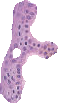

In [39]:
image.img

In [35]:
(image.img.size)[0]

109

In [15]:
im

In [19]:
objid

['0']

In [ ]:
im[]

In [20]:
im(image,area,objid)

TypeError: 'im' object is not callable

In [247]:
for classobj in classobj_list:
    print(classobj.area)

174434
124769
127227
128054
0
0
0
0
0
0
124171
128377


In [6]:
for i in range(0,5):
    folder_dir = img_path[i]
    class_im_list=[[] for i in range(13)]

    for path in folder_dir.glob('*.png'):
        image = Image.open(path)
        objid= re.findall("obj(\d+).png", ntpath.basename(path))
        image_arr = np.array(image) #change image into a numpy array?
        area = np.sum(image_arr>0) #get the area of image minus black background\
        im_obj = im(image,area,objid) #create an image object

        classid = re.findall("class(\d+)_", ntpath.basename(path))[0]

        class_im_list[int(classid)].append(im_obj)




    folder_mask_dir = mask_path[i]
    class_mask_list=[[] for i in range(13)]

    for path in folder_mask_dir.glob('*.png'):
        image = Image.open(path)
        objid= re.findall("obj(\d+).png", ntpath.basename(path))
        image_arr = np.array(image) #change image into a numpy array?
        area = np.sum(image_arr>0) #get the area of image minus black background\
        im_obj = im(image,area,objid) #create an image object

        classid = re.findall("classnew(\d+)_", ntpath.basename(path))[0]

        class_mask_list[int(classid)].append(im_obj)


    classobj_list=[]
    for id in iter_order:
        classobj_list.append(imclass(id,class_im_list[id],class_mask_list[id],0))


    filled_area = 0

    imgblank= Image.new(mode="RGB",size=DLinputsz)
    maskblank = Image.new(mode="L",size=DLinputsz)
    classblank = Image.new(mode="L",size=DLinputsz)

    #create random generator
    random.seed()


    #generate tiles
    class_notfull = True
    filled_class = []

    while(filled_area < collage_area and class_notfull):
        for classobj in classobj_list:
            r = len(classobj.im_list)
            # this is looping through the classobj_list again and again,
            # if you change "if" to "while", then it's looping through one class at a time
            if(classobj.area < class_area):
                #pick random images from this class and paste
                idx = random.randint(0, r-1)

                im = classobj.im_list[idx]
                mask = classobj.mask_list[idx]

                #TODO: maximum overlay
                #1.create a mask image,then subtract the two masks and get difference
                #if difference greater then max_overlay, then need to recalculate

                binary_mask = np.array(mask.img)
                binary_mask[binary_mask > 0] = 1
                old_mask = maskblank.copy()

                test_mask = maskblank.copy()
                #is this right?
                free_region_index = np.argwhere(np.array(maskblank)==0)
                xy = random.randint(0,len(free_region_index)-1)
                xycoord = tuple(free_region_index[xy])
                #check overlay
                overlay = np.sum(binary_mask) - np.sum(np.array(test_mask)- np.array(old_mask))

                #if too much overlapping, adjust xycoord
                #TODO: move on to the next one if it gets stuck too long

                #introduce new object to compiling tile
                attempt = 0
                max_overlapping_area= 500
                while(overlay > max_overlapping_area):
                    test_mask = maskblank.copy()
                    #randomly choose where to place excluding the filled area
                    # xycoord = (random.randint(0, DLinputsz[0]), random.randint(0, DLinputsz[1])) #create tuple of x,y coordinates to place on collage
                    xy = random.randint(0,len(free_region_index))
                    xycoord = tuple(free_region_index[xy])
                    #place object
                    test_mask.paste(Image.fromarray(binary_mask),xycoord,mask=Image.fromarray((np.array(binary_mask).astype('bool')*255)).convert('L'))
                    #check overlay: area of new object - area of potentially overlapping object in existing tile
                    overlay = np.sum(binary_mask) - np.sum(np.array(test_mask) - np.array(old_mask))
                    attempt += 1
                    if attempt > 10:
                        max_overlapping_area += 100

                #print(str(classobj.classid) + ","+ str(idx))
                maskblank.paste(Image.fromarray(binary_mask),xycoord,mask=Image.fromarray((np.array(binary_mask).astype('bool')*255)).convert('L'))
                imgblank.paste(im.img, xycoord, mask=Image.fromarray((np.array(mask.img).astype('bool')*255)).convert('L'))
                classblank.paste(mask.img,xycoord, mask=Image.fromarray((np.array(mask.img).astype('bool')*255)).convert('L'))
                #TODO: need to subtract area that is out of bounds

                cropped_area = np.sum(binary_mask)

                classobj.area = classobj.area + cropped_area

                #this filled area disgardes the area of overlapping, if want exact filled area, it's np.sum(maskblank)
                filled_area = filled_area + cropped_area
                #if we use the exact filled area, the classobj.area will be filled while the filled_area will not be filled
                #and the looop will run forever
                filled_area = np.sum(maskblank)

                #print(filled_area / collage_area)
                #print(classobj.area / class_area)
                #print(classobj.classid)
                #print('\n')

            #if all the class ares are filled but the image is not filled because of overlapping, just stop the iteration
            else:
                filled_class.append(classobj.classid)
                if(len(np.unique(filled_class)) == 12):
                    class_notfull = False


    imgblank.save(r'\\fatherserverdw\kyuex\great\tiles\obj{}.png'.format(i))
    classblank.save(r'\\fatherserverdw\kyuex\great\tiles\mask{}.png'.format(i))


    #reset class area to 0
    for classobj in classobj_list:
       classobj.area = 0

NameError: name 'class_area' is not defined

In [162]:
 print(i)

3


In [ ]:

for classobj in classobj_list:
    print(classobj.area)

In [ ]:
for i in range(1,11):
    filled_area = 0

    imgblank= Image.new(mode="RGB",size=DLinputsz)
    maskblank = Image.new(mode="L",size=DLinputsz)
    classblank = Image.new(mode="L",size=DLinputsz)

    #create random generator
    random.seed()

    while(filled_area < collage_area):
        for classobj in classobj_list:
            r = len(classobj.im_list)
            # this is looping through the classobj_list again and again,
            # if you change "if" to "while", then it's looping through one class at a time
            if(classobj.area < class_area):
                #pick random images from this class and paste
                idx = random.randint(0, r-1)
                print(str(classobj.classid) + ","+ str(idx))
                im = classobj.im_list[idx]
                mask = classobj.mask_list[idx]

                #TODO: maximum overlay
                #1.create a mask image,then subtract the two masks and get difference
                #if difference greater then max_overlay, then need to recalculate

                binary_mask = np.array(mask.img)
                binary_mask[binary_mask > 0] = 1
                old_mask = maskblank.copy()

                test_mask = maskblank.copy()
                #is this right?
                free_region_index = np.argwhere(np.array(maskblank)==0)
                xy = random.randint(0,len(free_region_index)-1)
                xycoord = tuple(free_region_index[xy])
                #check overlay
                overlay = np.sum(binary_mask) - np.sum(np.array(test_mask)- np.array(old_mask))

                #if too much overlapping, adjust xycoord
                #TODO: move on to the next one if it gets stuck too long

                #introduce new object to compiling tile
                attempt = 0
                max_overlapping_area= 500
                while(overlay > max_overlapping_area):

                    test_mask = maskblank.copy()
                    #randomly choose where to place excluding the filled area
                    # xycoord = (random.randint(0, DLinputsz[0]), random.randint(0, DLinputsz[1])) #create tuple of x,y coordinates to place on collage
                    xy = random.randint(0,len(free_region_index))
                    xycoord = tuple(free_region_index[xy])
                    #place object
                    test_mask.paste(Image.fromarray(binary_mask),xycoord,mask=Image.fromarray((np.array(binary_mask).astype('bool')*255)).convert('L'))
                    #check overlay: area of new object - area of potentially overlapping object in existing tile
                    overlay = np.sum(binary_mask) - np.sum(np.array(test_mask) - np.array(old_mask))
                    attempt += 1
                    if attempt > 10:
                        max_overlapping_area += 100

                maskblank.paste(Image.fromarray(binary_mask),xycoord,mask=Image.fromarray((np.array(binary_mask).astype('bool')*255)).convert('L'))
                imgblank.paste(im.img, xycoord, mask=Image.fromarray((np.array(mask.img).astype('bool')*255)).convert('L'))
                classblank.paste(mask.img,xycoord, mask=Image.fromarray((np.array(mask.img).astype('bool')*255)).convert('L'))
                #TODO: need to subtract area that is out of bounds

                cropped_area = np.sum(binary_mask) - overlay

                classobj.area = classobj.area + cropped_area

                #this filled area disgardes the area of overlapping, if want exact filled area, it's np.sum(maskblank)
                filled_area = filled_area + cropped_area
                #if we use the exact filled area, the classobj.area will be filled while the filled_area will not be filled
                #and the looop will run forever
                filled_area = np.sum(maskblank)




    imgblank.save(r'\\fatherserverdw\kyuex\great\tiles\2022-06-07 13.51.05-obj{}.png'.format(i))
    classblank.save(r'\\fatherserverdw\kyuex\great\tiles\2022-06-07 13.51.05-mask{}.png'.format(i))
    #reset area to 0
    for classobj in classobj_list:
        classobj.area = 0


In [ ]:
   #NOTE: i am not sure if this works, i am making pixels that are out of bounds zero
            #then cropped_area is the sum of pixels in arr_copy that is greater than zero

                if(max_x <  num_cols): #check if part of the img is out of bounds
                    for i in range (max_x,num_cols-1): #clear columns (x)
                        arr_copy[i] = 0

                if(max_y <  num_rows):
                    for i in range (max_y,num_rows-1): #clear rows (y)
                        arr_copy[:i] = 0

            #find max row and column of arr_copy
                copy_img = deepcopy(im.img)
                arr_copy = np.array(copy_img)
                num_rows = arr_copy.shape[1]
                num_cols = arr_copy.shape[0]


                cropped_area = np.sum(arr_copy>0)


                print(cropped_area)

In [ ]:

            max_x = (DLinputsz[0] - xycoord[0])
            max_y= DLinputsz[1] - xycoord[1]

            #find max row and column of arr_copy
            copy_img = deepcopy(im.img)
            arr_copy = np.array(copy_img)
            num_rows = arr_copy.shape[1]
            num_cols = arr_copy.shape[0]


            #NOTE: i am not sure if this works, i am making pixels that are out of bounds zero
            #then cropped_area is the sum of pixels in arr_copy that is greater than zero

            if(max_x <  num_cols): #check if part of the img is out of bounds
                for i in range (max_x,num_cols-1): #clear columns (x)
                    arr_copy[i] = 0

            if(max_y <  num_rows):
                for i in range (max_y,num_rows-1): #clear rows (y)
                    arr_copy[:i] = 0

            cropped_area = np.sum(arr_copy>0)

            #update filled_area and image total area
            classobj.area = classobj.area + cropped_area




In [ ]:
#create a list of im class to store: (image array, area, classid, objid)
im_list=list()
obj_num = 0 #number of objects in the class

for path in pathes:
    obj_num = obj_num + 1 #increment number of objects
    image = Image.open(path)
    objid= re.findall("obj(\d+).png", ntpath.basename(path))
    classid = re.findall("class(\d+)_", ntpath.basename(path))
    image_arr = np.array(image) #change image into a numpy array?
    area = np.sum(image_arr>0) #get the area of image minus black background\

    im_list.append(im(image,area,objid, 0,classid)) #add to the list of im classes


#the maximum area each object type could occupy
max_obj_area = collage_area / obj_num




In [ ]:
#create a list of masks
mask_list = list()
for path in mask_pathes:
    image = Image.open(path)
    objid= re.findall("obj(\d+).png", ntpath.basename(path))
    classid = re.findall("class(\d+)_", ntpath.basename(path))
    image_arr = np.array(image)
    mask_list.append(im(image,0,objid, 0,classid)) #don't need area


In [ ]:
#add collage to image, need to track filled_area
#need to track each class' area (need to loop through entire list, find same class ID and update total_area)

#Question: change the x,y coord of image to the center? (so that it could cut off the edge) ??

while(filled_area <= collage_area):
    #loop through im_list
    #TODO: check overlapping (need to keep track of which pixels are set)
    for im,mask in zip(im_list,mask_list):
        #if total_area hasn't exceeded designated area for each class
        while(im.total_area <= max_obj_area):
            xycoord = (random.randint(0, DLinputsz[0]), random.randint(0, DLinputsz[1])) #create tuple of x,y coordinates to place on collage
            imgblank.paste(im.img, xycoord, mask=Image.fromarray((np.array(mask.img).astype('bool')*255)).convert('L')) #paste im onto imgblank, xy coord is the upper left corner of im

            #----update areas here----

            #TODO: exclude area that is out of bounds
            #which row and colum to delete

            max_x = (DLinputsz[0] - xycoord[0])
            max_y= DLinputsz[1] - xycoord[1]

            #find max row and column of arr_copy
            copy_img = deepcopy(im.img)
            arr_copy = np.array(copy_img)
            num_rows = arr_copy.shape[1]
            num_cols = arr_copy.shape[0]


            #NOTE: i am not sure if this works, i am making pixels that are out of bounds zero
            #then cropped_area is the sum of pixels in arr_copy that is greater than zero

            if(max_x <  num_cols): #check if part of the img is out of bounds
                for i in range (max_x,num_cols-1): #clear columns (x)
                    arr_copy[i] = 0

            if(max_y <  num_rows):
                for i in range (max_y,num_rows-1): #clear rows (y)
                    arr_copy[:i] = 0

            cropped_area = np.sum(arr_copy>0)



            #update filled_area and image total area
            filled_area = filled_area + cropped_area

            #TODO: if there is more than one object in a class, need to loop through all the objects in that class
            #and update the total_area
            #class_list = [x for x in im_list if x.classid == im.classid]
            id = im.classid
            for image in im_list:
                if image.classid == id:
                    image.total_area = image.total_area + cropped_area  #used to be img.area


#display collage
imgblank.show()


In [ ]:
from matplotlib import pyplot as plt
plt.scatter([1,3,5,7],[1,3,5,7])

In [ ]:
plt.scatter([1,2,3,4,5,6,7],[1,2,3,4,5,6,7])